In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Directories for the dataset
train_dir = '/content/drive/MyDrive/dataset_path/dataset_path/train'
val_dir = '/content/drive/MyDrive/dataset_path/dataset_path/val'
test_dir = '/content/drive/MyDrive/dataset_path/dataset_path/test'

# Image parameters
img_height, img_width = 224, 224
batch_size = 5

# Data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add another dropout layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower initial learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for saving the best model, early stopping, and reducing learning rate
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, mode='min')

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // batch_size),
    validation_data=val_generator,
    validation_steps=max(1, val_generator.samples // batch_size),
    epochs=80,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Load the best model
model.load_weights('best_model.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=max(1, test_generator.samples // batch_size))
print(f'Test accuracy: {test_accuracy:.2f}')




Found 322 images belonging to 54 classes.
Found 55 images belonging to 54 classes.
Found 54 images belonging to 54 classes.
Epoch 1/80
64/64 [==============================] - 31s 163ms/step - loss: 4.3182 - accuracy: 0.0126 - val_loss: 9.2423 - val_accuracy: 0.0182 - lr: 0.0010
Epoch 2/80
64/64 [==============================] - 5s 79ms/step - loss: 4.1186 - accuracy: 0.0315 - val_loss: 24.1272 - val_accuracy: 0.0182 - lr: 0.0010
Epoch 3/80
64/64 [==============================] - 5s 77ms/step - loss: 4.0652 - accuracy: 0.0347 - val_loss: 19.0862 - val_accuracy: 0.0182 - lr: 0.0010
Epoch 4/80
64/64 [==============================] - 5s 78ms/step - loss: 3.9187 - accuracy: 0.0347 - val_loss: 20.3398 - val_accuracy: 0.0182 - lr: 0.0010
Epoch 5/80
64/64 [==============================] - 5s 75ms/step - loss: 3.7906 - accuracy: 0.0410 - val_loss: 13.5292 - val_accuracy: 0.0182 - lr: 0.0010
Epoch 6/80
64/64 [==============================] - 5s 76ms/step - loss: 3.6697 - accuracy: 0.0631 -

11/11 [==============================] - 1s 26ms/step


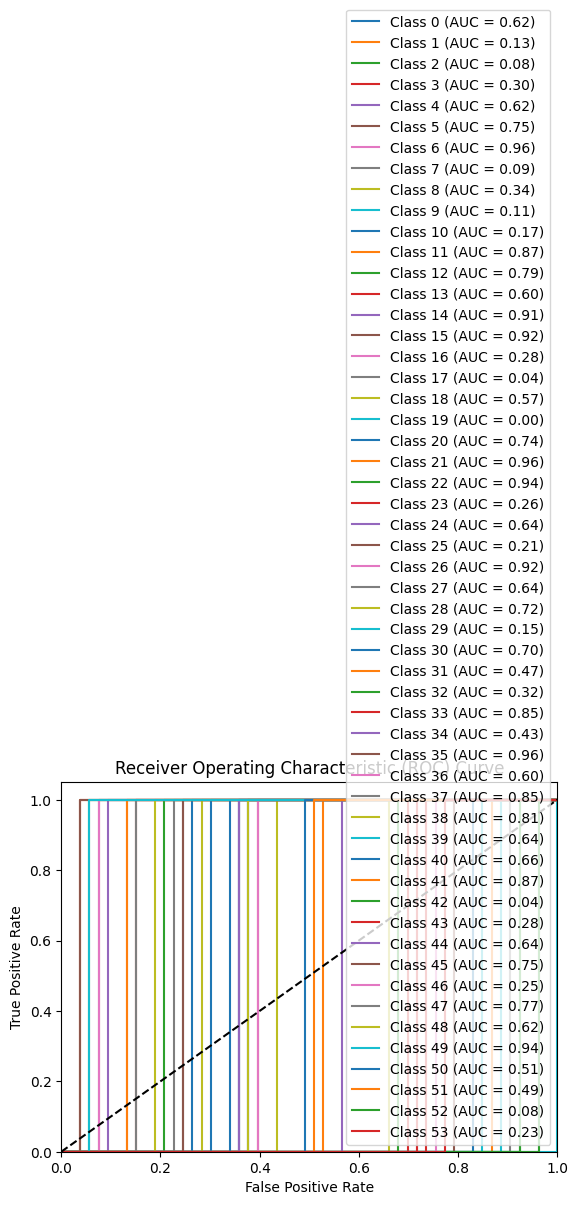

In [ ]:
# Generate predictions
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
y_true = test_generator.classes

# Generate predictions for all samples
y_pred = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure that y_true and y_pred_classes have the same length
assert len(y_true) == len(y_pred_classes), f"Mismatch: len(y_true) = {len(y_true)}, len(y_pred_classes) = {len(y_pred_classes)}"

# ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



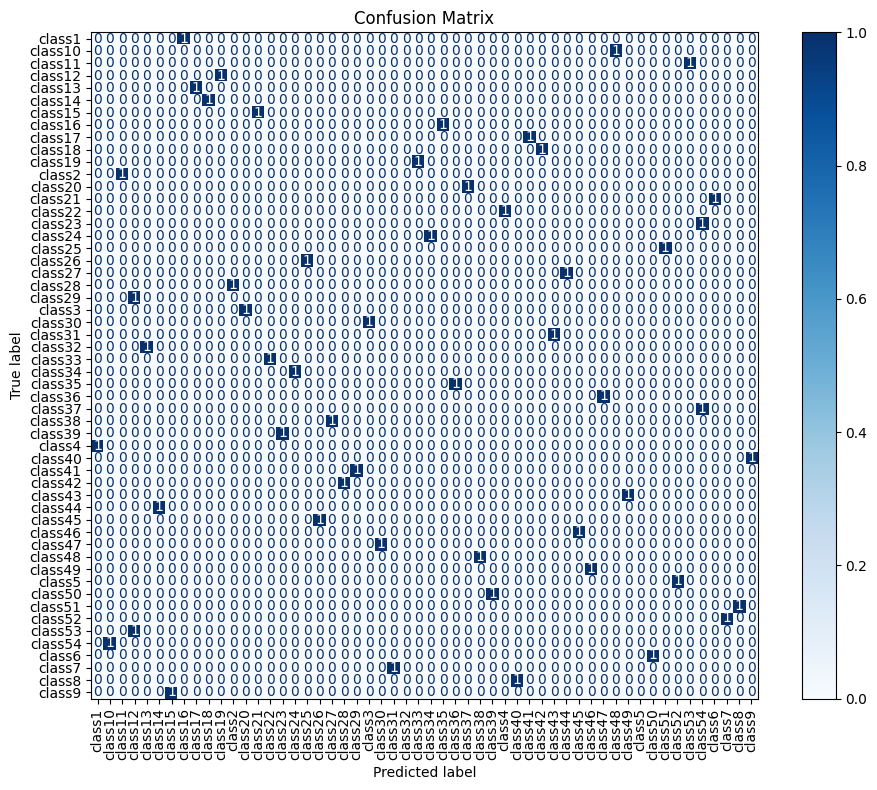

In [ ]:
plt.figure(figsize=(10, 8))  # Increase the figure size for the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
model = tf.keras.models.load_model('best_model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model as a .tflite file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Set the optimization flag for quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Representative dataset generator for post-training quantization
def representative_dataset():
    for n in range(100):
        # Generate or load an image, resize and normalize it as needed
        image = tf.random.normal([1, 224, 224, 3])
        yield [image]

converter.representative_dataset = representative_dataset

# Convert the model to TensorFlow Lite format with quantization
tflite_quant_model = converter.convert()

# Save the quantized model
with open('model_quant.tflite', 'wb') as f:
    f.write(tflite_quant_model)

# Read the quantized TensorFlow Lite model
with open('model_quant.tflite', 'rb') as f:
    model_content = f.read()

# Convert the model to a byte array
byte_array = ', '.join(f'0x{b:02x}' for b in model_content)

# Save the byte array to a header file
with open('model_data.h', 'w') as f:
    f.write(f'const unsigned char model[] = {{{byte_array}}};\n')
    f.write(f'const int model_len = {len(model_content)};\n')

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
